<a href="https://colab.research.google.com/github/jiukeem/deeplearning_from_scratch/blob/master/L2_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [4]:
x_train.shape, x_val.shape

((364, 30), (91, 30))

In [5]:
# normalization 
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [6]:
x_val_scaled = (x_val - train_mean) / train_std

In [7]:
class SingleLayer:
  def __init__(self, learning_rate=0.1, l2=0):
    self.w = None
    self.b = None
    self.cost_history = []
    self.lr = learning_rate
    self.val_cost_history = [] # 러닝커브를 보기 위함
    self.l2_lambda = l2
        
  def initialization(self, x):
    self.w = np.ones(x.shape[1]) # 이렇게 설정하면 (1, nx) 일지 (nx, 1) 일지 어떻게 알지?
    self.b = 0
    return self.w, self.b

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def forward_prop(self, x):
    z = np.sum(x * self.w) + self.b
    a = self.sigmoid(z)
    return a

  def calcul_loss(self, a, y):
    a = np.clip(a, 1e-10, 1-1e-10)
    loss = -(y * np.log(a) + (1 - y) * np.log(1 - a)) + self.l2_lambda * np.sum(self.w **2) / 2
    return loss

  def backward_prop(self, x, y, a):
    dw = (a - y) * x + self.l2_lambda * self.w
    db = (a - y) * 1 
    return dw, db

  def fit(self, x, y, epoches=100, x_val=None, y_val=None):
    self.w, self.b = self.initialization(x)
    for i in range(epoches):
      loss = 0
      index = np.random.permutation(np.arange(len(x)))
      for i in index:
        a = self.forward_prop(x[i])
        dw, db = self.backward_prop(x[i], y[i], a)
        self.w -= dw * self.lr
        self.b -= db * self.lr
        loss += self.calcul_loss(a, y[i])        
      self.cost_history.append(loss / x.shape[0])
      self.update_val_loss(x_val, y_val)

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(x_val.shape[0]):
      a_val = self.forward_prop(x_val[i])
      val_loss += self.calcul_loss(a_val, y_val[i])
    self.val_cost_history.append(val_loss / x_val.shape[0])

  def predict(self, x): # 여기 x는 2차원 행렬로 들어온다
    a = [self.forward_prop(x_row) for x_row in x] # 이렇게 하면 각 row가 요소가 되는 듯?
    y_hat = [i > 0.5 for i in a]
    return y_hat
      
  def score(self, x, y):
    y_hat = self.predict(x)
    score = np.mean(y_hat == y)
    return score      

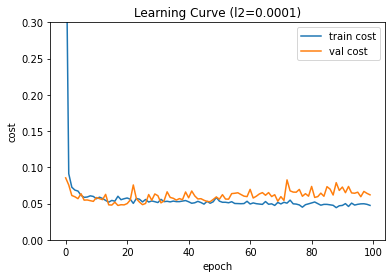

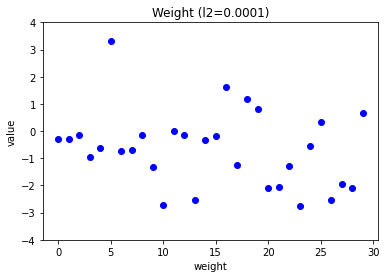

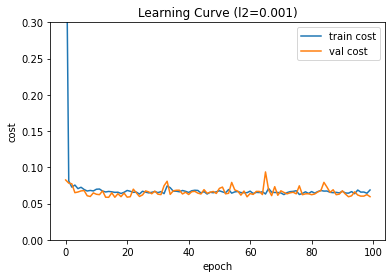

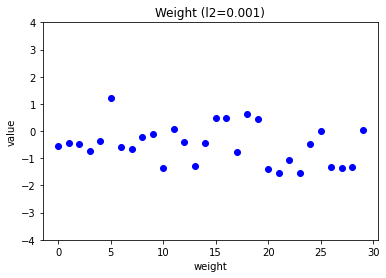

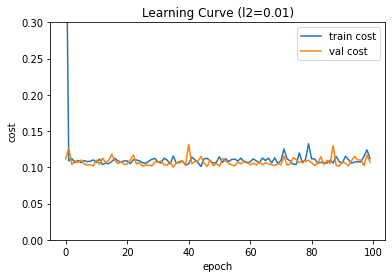

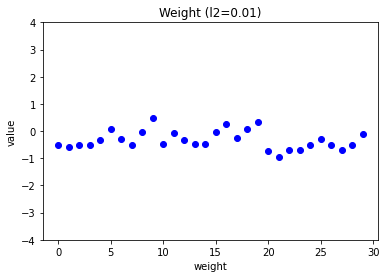

In [9]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  layer = SingleLayer(l2=l2)
  layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(layer.cost_history)
  plt.plot(layer.val_cost_history)
  plt.title('Learning Curve (l2={})'.format(l2))
  plt.ylabel('cost')
  plt.xlabel('epoch')
  plt.legend(['train cost', 'val cost'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(layer.w, 'bo')
  plt.title('Weight (l2={})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

In [11]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42) #여기서 알파는 learning rate가 아니라 regularization 앞에 붙는 람다인 듯 함
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978